In [1]:
%pylab inline
from astropy.cosmology import WMAP9
from simqso.sqgrids import *
from simqso import sqbase
from simqso import hiforest
from simqso.sqrun import buildSpectraBySightLine,buildQsoSpectrum
from simqso import sqphoto

Populating the interactive namespace from numpy and matplotlib


In [2]:
M = AbsMagVar(UniformSampler(-29,-24),restWave=1450)
z = RedshiftVar(UniformSampler(4.7,5.3))
lya = GaussianLineEqWidthVar(UniformSampler(0,2.5),'logLyaEW',1215.67,10.,log=True)
dust = SMCDustVar(UniformSampler(0,0.2))
qsoGrid = QsoSimGrid([M,z,lya,dust],(10,5,4,5),50,cosmo=WMAP9,units='luminosity')

In [3]:
qsoGrid.gridShape,len(qsoGrid.data)

((10, 5, 4, 5, 50), 50000)

In [4]:
# cover 3000A to 5um at R=500
wave = sqbase.fixed_R_dispersion(3000,5e4,500)

In [5]:
forestSpec = hiforest.IGMTransmissionGrid(wave,100,zmax=5.3,ForestModel='McGreer+2013')
forestVar = HIAbsorptionVar(forestSpec)

In [6]:
# the "expdust" continuum model from Ross+13
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-0.5,0.2),
                                      GaussianSampler(-0.3,0.2)],
                                     [1100.])
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsoGrid.absMag,ExcludeLines=['LyAn','LyAb'])
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsoGrid.z,wave,scales=fescales))
# Now add the features to the QSO grid
qsoGrid.addVars([contVar,emLineVar,feVar,forestVar])

using Fe scales:  [(0, 1540, 0.5), (1540, 1680, 2.0), (1680, 1868, 1.6), (1868, 2140, 1.0), (2140, 3500, 1.0)]


In [7]:
photPar = {
    'PhotoSystems':[
      ('SDSS','Legacy'),
      ('UKIRT','UKIDSS_LAS'),
    ]
  }
photoMap = sqphoto.load_photo_map(photPar)

In [8]:
# ready to generate spectra
_ = buildSpectraBySightLine(wave,qsoGrid,map,photoMap=photoMap,verbose=1)

simulating  50000  quasar spectra
units are  luminosity
max number iterations:  1
processing  503  obj in group  0


(-0.5, 1.3)

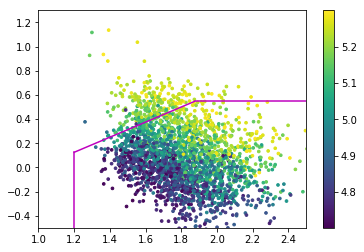

In [9]:
g_mags = qsoGrid.asGrid('synMag')
g_z = qsoGrid.asGrid('z')
scatter(g_mags[:,:,-1,0,:,2]-g_mags[:,:,-1,0,:,3],
        g_mags[:,:,-1,0,:,3]-g_mags[:,:,-1,0,:,4],
       c=g_z[:,:,-1,0,:],s=7)
colorbar()
plot([1.2,1.2],[-0.5,0.13],c='m')
plot([1.875,2.5],[0.55,0.55],c='m')
ri = linspace(1.2,1.875,2)
plot(ri,polyval([0.625,0],ri-1),c='m')
xlim(1.0,2.5)
ylim(-0.5,1.3)

In [10]:
photoData = sqphoto.calcObsPhot(qsoGrid.synFlux,photoMap)
qsoGrid.addData(photoData)

In [11]:
#g_mags = qsoGrid.asGrid('obsMag')
g_mags = qsoGrid.asGrid('synMag')
r_minus_i = g_mags[...,2] - g_mags[...,3]
i_minus_z = g_mags[...,3] - g_mags[...,4]
color_sel = ( (r_minus_i>1.2) & 
              (i_minus_z < 0.625*(r_minus_i-1)) &
              (i_minus_z<0.55)
            )

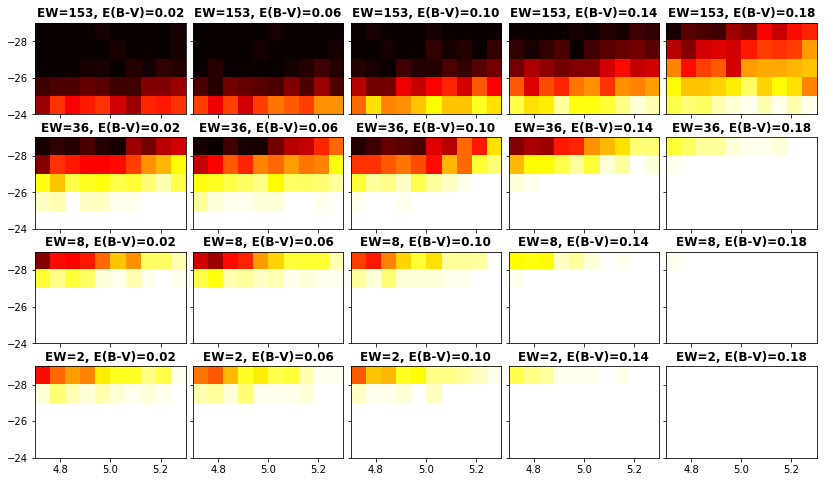

In [12]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4,5)
gs.update(wspace=0.05,hspace=0.25)
figure(figsize=(14,8))
for i in range(4):
    for j in range(5):
        ax = plt.subplot(gs[i,j])
        if j>0: ax.yaxis.set_ticklabels([])
        if i<3: ax.xaxis.set_ticklabels([])
        fsel = color_sel[:,:,-(i+1),j].sum(axis=-1) / 50.
        imshow(fsel.T,vmin=0,vmax=1,extent=[4.7,5.3,-24,-29],
               interpolation='nearest',aspect='auto',cmap=cm.hot_r)
        title('EW=%d, E(B-V)=%.2f' %
              (10**qsoGrid.gridCenters[2][-(i+1)],qsoGrid.gridCenters[3][j]),size=12,weight='bold')

[750 850 950]


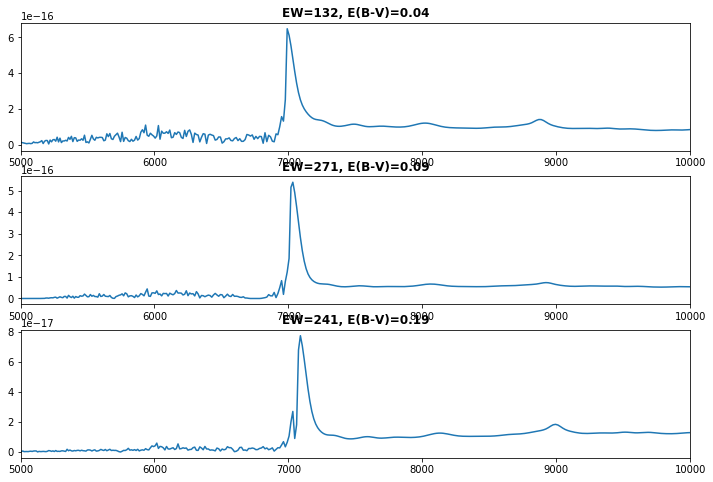

In [13]:
specFeatures = qsoGrid.getVars(SpectralFeatureVar)
ii = np.array([np.ravel_multi_index(t,qsoGrid.gridShape)
               for t in [(0,0,3,0,0),(0,0,3,2,0),(0,0,3,4,0)]])
print ii
figure(figsize=(12,8))
for _i,i in enumerate(ii):
    subplot(3,1,_i+1)
    obj = qsoGrid.data[i]
    sp, = buildQsoSpectrum(wave,qsoGrid.cosmo,specFeatures,obj,saveSpectra=True)
    plot(wave,sp)
    title('EW=%d, E(B-V)=%.2f' %
              (10**obj['logLyaEW'],obj['smcDustEBV']),size=12,weight='bold')
    xlim(5000,1e4)